# シグモイド関数、損失関数の定義

- シグモイド関数 (Sigmoid Function)  
$\sigma(x) = \frac{1}{1 + e^{-x}}, \quad \sigma'(x) = \sigma(x)(1 - \sigma(x))$
  
- 損失関数 (二乗誤差)  
$E(y) = \frac{1}{2}(y - t)^2, \quad E'(y) = y - t$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#-------------
# シグモイド関数
#-------------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):  #微分形
    y = sigmoid(x)
    return y*(1-y)

#-----------
# 損失関数
#-----------
def Loss(y,t):
    E = (y-t)**2/2
    return E
def d_Loss(y,t):  #微分形
    return y-t

# ニューロンクラスの実装

- 順伝播  
  - $a = [input1]w_1 + [input2]w_2 + \dots +b$  
  - $[output] = \sigma(a)$  
  
- 逆伝播  
  - $\frac{\partial E}{\partial w_N} = [G\_input]\frac{\partial [output]}{\partial a}\ [inputN]\ (N=1,2,,,)$  
  - $\frac{\partial E}{\partial b} = [G\_input]\frac{\partial [output]}{\partial a}$  
  - $[G\_outputN] = [G\_input]\frac{\partial [output]}{\partial a}\ w_N\ (N=1,2,,,)$

- パラメータ更新
  - $w_N ← w_N-\eta\times\frac{\partial E}{\partial w_N}$
  - $b ← b-\eta\times\frac{\partial E}{\partial b}$

In [2]:
class Neuron:
    #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, w_num, lr):  # (重みの数, 学習係数)
        self.a = 0           # 重み付き和
        self.eta = lr        # 学習係数
        self.z_in = []       # 入力値
        self.z_out = 0       # 出力値
        self.DG_out = 0      # 前の層へ渡す誤差
        self.w = np.random.randn(w_num)  # 重みを標準正規分布で初期化
        self.dw = np.zeros(w_num)        # 重みの勾配
        self.b = np.random.randn()       # バイアスを標準正規分布で初期化
        self.db = 0                      # バイアスの勾配

    #--------
    # 順伝播
    #--------
    def forward(self, x):
        self.z_in = np.array(x)   # 入力のリストをNumpy形式に変更
        input_sum = 0
        for i in range(len(self.z_in)):
            input_sum += self.w[i] * self.z_in[i]  # 重み×入力
        input_sum += self.b                        # バイアスを加算
        self.a = input_sum              # 重み付き和を更新
        self.z_out = sigmoid(self.a)    # 重み付き和に活性化関数を作用
        return self.z_out

    #--------
    # 逆伝播
    #--------
    def backward(self, DG_in):
        DG_tmp = DG_in * d_sigmoid(self.a)  # 誤差の総和に活性化関数の微分をかける
        self.dw = DG_tmp * self.z_in   # 重みの勾配の算出
        self.db = DG_tmp               # バイアスの勾配の算出
        self.DG_out = DG_tmp * self.w  # 前の層へ送る誤差の算出(ブロードキャストにより重みのサイズに拡張される)
        return self.DG_out

    #-----------------
    # パラメータの更新
    #-----------------
    def param_updata(self):
        self.w -= self.eta * self.dw   # 学習係数×重みの勾配
        self.b -= self.eta * self.db   # 学習係数×バイアスの勾配

    #--------------------------------
    # パラメータの取得(必要があれば)
    #--------------------------------
    def get_params(self):
        return [self.w, self.b]

# レイヤークラスの実装
- 順伝播
  - 前層からの入力をニューロンへ渡す
  - 各ニューロンからの出力をリストにまとめて次層に出力する

- 逆伝播
  - 次層からのニューロン毎の出力をそれぞれのニューロンへ渡す
  - 各ニューロンからの経路に対する出力を集め、経路毎に足し合わせたものを前層に出力する

- パラメータ更新
  - ニューロンごとにパラメータ更新を行う

In [3]:
class Layer:
    #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, input_size, lr, NumOfNeuron):  # (入力のサイズ, 学習係数, ニューロンの数)
        self.NumOfNeuron = NumOfNeuron  # ニューロンの個数
        self.Neurons = []
        # 必要数分ニューロンのインスタンスを作成し、リストで保存する
        for i in range(self.NumOfNeuron):
            new_nueron = Neuron(input_size, lr)
            self.Neurons.append(new_nueron)

    #--------
    # 順伝播
    #--------
    def forward(self, x):
        z_outs = []
        # 層全体の順伝播：全ニューロンの出力を集める
        for i in range(self.NumOfNeuron):
            z_outs.append(self.Neurons[i].forward(x))
        return np.array(z_outs)  #Numpy形式で出力

    #--------
    # 逆伝播
    #--------
    def backward(self, DG_in):
        DG_in = np.atleast_1d(DG_in)  # (最低でも一次元の)配列に変換
        DG_outs = []
        # for i in range(self.NumOfNeuron):
        #     # 各ニューロンに対応する誤差を渡す
        #     if i < len(DG_in):
        #         dg = DG_in[i]
        #     else:
        #         dg = 0
        #     DG_outs.append(self.Neurons[i].backward(dg))  #各ニューロンの誤差の出力をリストにまとめる
        for i in range(self.NumOfNeuron):
          # 各ニューロンに対応する誤差を渡す
          DG_outs.append(self.Neurons[i].backward(DG_in[i]))  #各ニューロンの誤差の出力をリストにまとめる
        return np.sum(np.array(DG_outs), axis=0)          # 前の層へは列ごとの合計(全ニューロンからの担当分の勾配の和)を返す

    #-----------------
    # パラメータの更新
    #-----------------
    def param_updata(self):
        #ニューロンごとに重み、バイアスを一括更新
        for i in range(self.NumOfNeuron):
            self.Neurons[i].param_updata()

    #--------------------------------
    # パラメータの取得(必要があれば)
    #--------------------------------
    def get_params(self):
        w = []
        b = []
        for i in range(self.NumOfNeuron):
            w_tmp, b_tmp = self.Neurons[i].get_params()
            w.append(w_tmp)
            b.append(b_tmp)
        return [w, b]

# ニューラルネットワーククラスの実装
- 順伝播
  - 入力層→隠れ層1→隠れ層2→出力層
- 逆伝播
  - 損失関数→出力層→隠れ層2→隠れ層1（→入力層）
- パラメータ更新
  - 各層のパラメータ更新を実施


In [4]:
class NeuralNetwork:
   #----------------------
    # インスタンスの初期化
    #----------------------
    def __init__(self, input_size, neuron_num_per_layer, output_size, lr):   # (入力サイズ, 隠れ層のニューロンの数, 出力サイズ(1), 学習係数)
        self.E = 0     # 損失
        self.d_E = 0   # 損失の微分
        self.outsize = output_size
        self.output = np.zeros(output_size)
        self.Layer1 = Layer(input_size, lr, neuron_num_per_layer)            # 隠れ層1
        self.Layer2 = Layer(neuron_num_per_layer, lr, neuron_num_per_layer)  # 隠れ層2
        self.OutLayer = Layer(neuron_num_per_layer, lr, output_size)         # 出力層

    #--------
    # 順伝播
    #--------
    def FORWARD(self, x, t):
        layer1_out = self.Layer1.forward(x)                # 入力層→隠れ層1
        layer2_out = self.Layer2.forward(layer1_out)       # 隠れ層1→隠れ層2
        OutLayer_out = self.OutLayer.forward(layer2_out)   # 隠れ層2→出力層
        self.output = OutLayer_out
        return OutLayer_out

    #--------
    # 逆伝播
    #--------
    def BACKWARD(self, t):
        self.E = Loss(self.output, t)      # 損失の算出
        self.d_E = d_Loss(self.output, t)  # 損失の勾配を算出
        DG = self.d_E                      # 損失の勾配を出力層の逆伝播の入力とする
        DG_OutLayer = self.OutLayer.backward(DG)       # 損失→出力層
        DG_Layer2 = self.Layer2.backward(DG_OutLayer)  # 出力層→隠れ層2
        DG_Layer1 = self.Layer1.backward(DG_Layer2)    # 隠れ層2→隠れ層1

    #-----------------
    # パラメータの更新
    #-----------------
    def PARAM_UPDATA(self):
        # 全層のパラメータを更新
        self.Layer1.param_updata()
        self.Layer2.param_updata()
        self.OutLayer.param_updata()

# XORの学習
1. XORのデータを作成
2. ニューラルネットワークのインスタンスの生成
3. 学習の実施
4. 学習の成果を確認

Epoch 0:Ave Loss = 0.136260
Epoch 500:Ave Loss = 0.125299
Epoch 1000:Ave Loss = 0.124679
Epoch 1500:Ave Loss = 0.123717
Epoch 2000:Ave Loss = 0.121923
Epoch 2500:Ave Loss = 0.117960
Epoch 3000:Ave Loss = 0.108072
Epoch 3500:Ave Loss = 0.083221
Epoch 4000:Ave Loss = 0.039055
Epoch 4500:Ave Loss = 0.016396
Epoch 5000:Ave Loss = 0.008885
Epoch 5500:Ave Loss = 0.005750
Epoch 6000:Ave Loss = 0.004138
Epoch 6500:Ave Loss = 0.003186
Epoch 7000:Ave Loss = 0.002568
Epoch 7500:Ave Loss = 0.002139
Epoch 8000:Ave Loss = 0.001826
Epoch 8500:Ave Loss = 0.001588
Epoch 9000:Ave Loss = 0.001402
Epoch 9500:Ave Loss = 0.001254
*******************
入力 = [0 0]
出力予測値 = 0.04232426512203922
出力正解値 = 0
*******************
入力 = [0 1]
出力予測値 = 0.9515025347342204
出力正解値 = 1
*******************
入力 = [1 0]
出力予測値 = 0.954181578078965
出力正解値 = 1
*******************
入力 = [1 1]
出力予測値 = 0.052981829202073
出力正解値 = 0


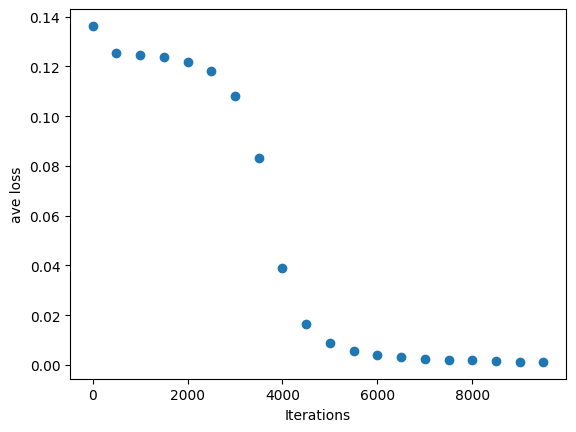

In [5]:
#---------------------
# XORの入力データ作成
#---------------------
# 2入力の場合
x_data = np.array([[0,0],\
                   [0,1],\
                   [1,0],\
                   [1,1]])
t_data = np.array([0,\
                   1,\
                   1,\
                   0])

# 3入力の場合
# x_data = np.array([[0,0,0],\
#                    [0,0,1],\
#                    [0,1,0],\
#                    [0,1,1],\
#                    [1,0,0],\
#                    [1,0,1],\
#                    [1,1,0],\
#                    [1,1,1]])
# t_data = np.array([0,\
#                    1,\
#                    1,\
#                    0,\
#                    1,\
#                    0,\
#                    0,\
#                    1])


#------------------------
# ニューロンの各種設定
#------------------------
input_size = len(x_data[0])  # 入力サイズ
neuron_num_per_layer = 4     # 隠れ層のニューロン数
out_size = 1                 # 出力サイズ
lr = 0.08                    # 学習係数


#------------------------
# モデルのインスタンス化
#------------------------
NN = NeuralNetwork(input_size, neuron_num_per_layer, out_size, lr)


# --- 学習の実行 ---
iter_num = 10000   # 繰り返し回数
iter_list = []     # グラフ用：繰り返し回数の記録
E_list = []        # グラフ用：損失の記録
W_list = []        # グラフ用(参考)：重みの記録
B_list = []        # グラフ用(参考)：バイアスの記録

#--------------
# モデルの学習
#--------------
for n in range(iter_num):
    total_loss = 0     # 学習の度に損失合計をクリア
    for i in range(len(x_data)):
        a = NN.FORWARD(x_data[i], t_data[i])  # 順伝播
        NN.BACKWARD(t_data[i])                # 逆伝播
        NN.PARAM_UPDATA()                     # パラメータの更新
        total_loss += NN.E.item()             # 損失を加算(※順伝播の出力をnumpy型にしているため、スカラーに変換)

    # 500回ごとに進捗表示
    if n % 500 == 0:
      ave_loss = total_loss/len(x_data)    # 平均損失の算出
      print(f"Epoch {n}:Ave Loss = {ave_loss:.6f}")
      iter_list.append(n)
      E_list.append(ave_loss)
      w, b = NN.OutLayer.get_params()
      B_list.append(b)

#--------------------
# 学習後の結果を表示
#--------------------
for i in range(len(x_data)):
    result = NN.FORWARD(x_data[i], t_data[i])
    print("*******************")
    print("入力 =",x_data[i])            # 入力を表示
    print("出力予測値 =",result.item())  # 出力結果を表示
    print("出力正解値 =",t_data[i])      # 正解値を表示

#--------------
# 結果の可視化
#--------------
# 損失の推移をプロット
plt.scatter(iter_list, E_list)
plt.xlabel("Iterations")  # 横軸：繰り返し回数
plt.ylabel("ave loss")  # 縦軸：平均損失
plt.show()
